In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
data_dir = '/content/drive/MyDrive/PLSU/'

In [4]:
img_size = (150, 150)
batch_size = 8

In [49]:
data_df = pd.read_excel(data_dir + 'label.xlsx', engine='openpyxl')
data_df

,File Number,life,head,heart,label
0,1,0,0,0,000
1,2,0,0,0,000
2,5,0,1,0,010
3,12,0,0,1,001
4,13,0,1,0,010
...,...,...,...,...,...
1031,5354,1,0,1,101
1032,5366,0,0,0,000
1033,5367,0,0,0,000
1034,5372,0,-,1,0-1


In [50]:
data_df = data_df[(data_df['life'] != '-') & (data_df['life'] != '')]
data_df = data_df[(data_df['head'] != '-') & (data_df['head'] != '')]
data_df = data_df[(data_df['heart'] != '-') & (data_df['heart'] != '')]
data_df

,File Number,life,head,heart,label
0,1,0,0,0,000
1,2,0,0,0,000
2,5,0,1,0,010
3,12,0,0,1,001
4,13,0,1,0,010
...,...,...,...,...,...
1030,5353,0,0,1,001
1031,5354,1,0,1,101
1032,5366,0,0,0,000
1033,5367,0,0,0,000


In [51]:
def reconstruct_file_name(file_number):
    return 'image' + str(file_number) + '.png'

data_df['file'] = data_df['File Number'].apply(reconstruct_file_name)
del data_df['File Number']

data_df

,life,head,heart,label,file
0,0,0,0,000,image1.png
1,0,0,0,000,image2.png
2,0,1,0,010,image5.png
3,0,0,1,001,image12.png
4,0,1,0,010,image13.png
...,...,...,...,...,...
1030,0,0,1,001,image5353.png
1031,1,0,1,101,image5354.png
1032,0,0,0,000,image5366.png
1033,0,0,0,000,image5367.png


In [52]:
data_df['label'].value_counts()

000    225
001    220
100    131
101    112
010    104
011     92
110     70
111     42
Name: label, dtype: int64

In [53]:
mapping_dict = {
    '000': '0',
    '001': '1',
    '010': '2',
    '011': '3',
    '100': '4',
    '101': '5',
    '110': '6',
    '111': '7'
}

data_df['label'] = data_df['label'].apply(lambda x: mapping_dict[x])
data_df

,life,head,heart,label,file
0,0,0,0,0,image1.png
1,0,0,0,0,image2.png
2,0,1,0,2,image5.png
3,0,0,1,1,image12.png
4,0,1,0,2,image13.png
...,...,...,...,...,...
1030,0,0,1,1,image5353.png
1031,1,0,1,5,image5354.png
1032,0,0,0,0,image5366.png
1033,0,0,0,0,image5367.png


In [37]:
train_df = data_df.sample(frac=0.8, random_state=42)
valid_df = data_df.drop(train_df.index).sample(frac=0.5, random_state=42)
test_df = data_df.drop(train_df.index).drop(valid_df.index)
print(len(train_df), len(valid_df), len(test_df))

797 100 99


In [54]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

In [55]:
data_generator = ImageDataGenerator(rescale=1./255)

In [56]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    data_dir+'Mask',
    x_col='file',
    y_col='label',
    # y_col='heart',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
    # class_mode='raw'
)

valid_generator = data_generator.flow_from_dataframe(
    valid_df,
    data_dir+'Mask',
    x_col='file',
    y_col='label',
    # y_col='heart',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
    # class_mode='raw'
)

Found 797 validated image filenames belonging to 8 classes.
Found 100 validated image filenames belonging to 8 classes.


In [57]:
# CNN 모델 생성
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
# model.add(layers.Dense(1, activation='sigmoid'))

In [58]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
# 모델 학습
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_checkpoint_path = data_dir + 'model_checkpoint.h5'
early_stopping_patience = 5

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=early_stopping_patience)
model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
99/99 [==============================] - ETA: 0s - loss: 2.0085 - accuracy: 0.2155
Epoch 1: val_accuracy improved from -inf to 0.15625, saving model to /content/drive/MyDrive/PLSU/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 23s 216ms/step - loss: 2.0085 - accuracy: 0.2155 - val_loss: 1.9835 - val_accuracy: 0.1562
Epoch 2/30
99/99 [==============================] - ETA: 0s - loss: 1.9908 - accuracy: 0.2307
Epoch 2: val_accuracy improved from 0.15625 to 0.25000, saving model to /content/drive/MyDrive/PLSU/model_checkpoint.h5
99/99 [==============================] - 23s 229ms/step - loss: 1.9908 - accuracy: 0.2307 - val_loss: 1.9884 - val_accuracy: 0.2500
Epoch 3/30
99/99 [==============================] - ETA: 0s - loss: 1.9742 - accuracy: 0.2281
Epoch 3: val_accuracy did not improve from 0.25000
99/99 [==============================] - 24s 244ms/step - loss: 1.9742 - accuracy: 0.2281 - val_loss: 1.9742 - val_accuracy: 0.1667
Epoch 4/30
99/99 [==============================] - ETA: 0s - loss: 1.9759 - accuracy: 0.2041
Epoch 4: val_accuracy did not improve from 0.25000
99/99 [==============================] - 21s 210ms/step - loss: 1.9759 - accuracy: 0.2041 - val_loss

In [60]:
test_generator = data_generator.flow_from_dataframe(
    test_df,
    data_dir+'Mask',
    x_col='file',
    y_col='label',
    # y_col='heart',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
    # class_mode='raw'
)

Found 99 validated image filenames belonging to 8 classes.


In [61]:
from tensorflow.keras.models import load_model

loaded_model = load_model(model_checkpoint_path)
loss, accuracy = loaded_model.evaluate(test_generator, steps=len(test_generator))

13/13 [==============================] - 3s 207ms/step - loss: 1.5060 - accuracy: 0.5354


In [62]:
import numpy as np
from sklearn.metrics import f1_score

y_pred = loaded_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred_classes

13/13 [==============================] - 2s 161ms/step


array([2, 6, 0, 3, 1, 0, 1, 5, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 2, 7, 6, 3, 3, 1, 0, 7, 0, 2, 1, 5, 1, 0, 0, 1, 2,
       4, 6, 1, 3, 5, 6, 5, 0, 0, 4, 6, 2, 1, 1, 1, 6, 1, 2, 5, 6, 4, 2,
       1, 1, 0, 0, 1, 1, 1, 7, 6, 4, 1, 2, 2, 3, 5, 0, 1, 6, 5, 1, 0, 0,
       1, 1, 0, 1, 0, 4, 3, 0, 1, 0, 1])

In [63]:
y_true = test_generator.classes

f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f1)

0.1755516927074061


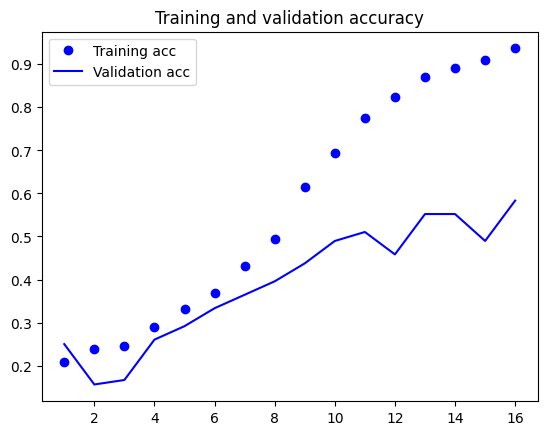

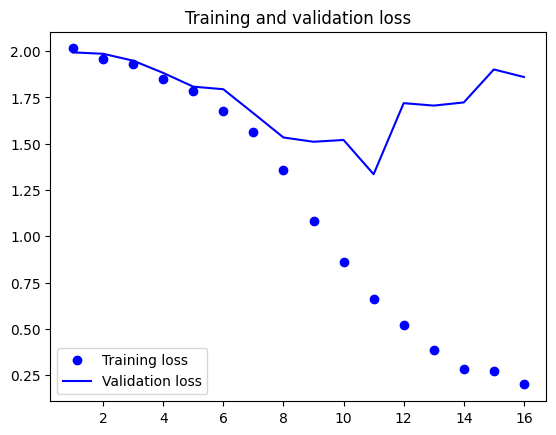

In [48]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()